In [ ]:
!pip install transformers datasets -U

In [1]:
# Use a pipeline as a high-level helper
from huggingface_hub import login
from transformers import pipeline

In [2]:
login()

In [3]:
model_name = "meta-llama/Llama-3.1-8B-Instruct"
pipe = pipeline("text-generation", model=model_name)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


<Axes: >

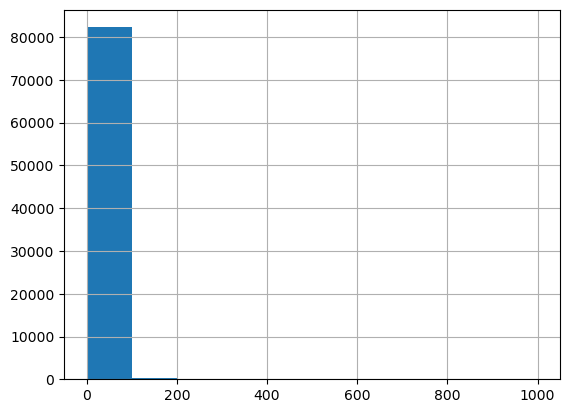

In [36]:
import pandas as pd

reddit_jokes_df = pd.read_json("reddit_jokes.json")
reddit_jokes_df["joke"] = reddit_jokes_df["title"] + " " + reddit_jokes_df["body"]
reddit_jokes_df = reddit_jokes_df[reddit_jokes_df["joke"].str.split().str.len() <= 24]
reddit_jokes_df = reddit_jokes_df[reddit_jokes_df["joke"].str.split().str.len() >= 5]
reddit_jokes_df = reddit_jokes_df[reddit_jokes_df["score"].astype(int) > 0]
reddit_jokes_df["score"] = reddit_jokes_df["score"] / reddit_jokes_df["score"].max() * 1000

reddit_jokes_df["score"].hist()

In [37]:
reddit_jokes_list = reddit_jokes_df.joke.to_list()
reddit_jokes_list[:5]

['I hate how you cant even say black paint anymore Now I have to say "Leroy can you please paint the fence?"',
 "If I get a bird I'm naming it Trump cuz all they do is Tweet",
 'What do you call an exercise machine with a strobe light? An epileptical. ',
 'My dad has a heart of a lion ...and a lifetime ban from the local zoo. ',
 'Smaller babies may be delivered by a stork. But the bigger, heavier ones are delivered by a crane. ']

In [38]:
len(reddit_jokes_list)

82781

In [8]:
import random

def generate_common_pairs(n=1000):
    verbs = [
        "accept", "add", "ask", "be", "become", "begin", "believe", "bring", "build", "buy",
        "call", "can", "carry", "catch", "change", "choose", "clean", "close", "come", "consider",
        "continue", "cook", "cost", "cut", "dance", "decide", "describe", "develop", "die", "do",
        "draw", "drink", "drive", "eat", "enjoy", "expect", "explain", "fall", "feel", "fight",
        "find", "finish", "fly", "forget", "forgive", "get", "give", "go", "grow", "guess",
        "handle", "happen", "have", "hear", "help", "hold", "hope", "imagine", "improve", "include",
        "increase", "keep", "know", "learn", "leave", "let", "like", "listen", "live", "look",
        "lose", "love", "make", "manage", "mean", "meet", "move", "need", "notice", "open",
        "order", "own", "pay", "play", "prepare", "produce", "prove", "put", "read", "receive",
        "remember", "reply", "run", "say", "see", "sell", "send", "set", "show", "sing",
        "sit", "sleep", "smile", "speak", "spend", "stand", "start", "stay", "stop", "study",
        "suggest", "support", "take", "talk", "teach", "tell", "think", "travel", "try", "turn",
        "understand", "use", "visit", "wait", "walk", "want", "watch", "win", "work", "write",
        "accept", "act", "allow", "apply", "arrive", "avoid", "belong", "break", "burn", "call",
        "carry", "change", "check", "choose", "climb", "compare", "complain", "connect", "decide", "deliver",
        "design", "discover", "enjoy", "enter", "explain", "fill", "fix", "guess", "hate", "hold",
        "join", "kill", "laugh", "lead", "measure", "miss", "offer", "plan", "push", "reach",
        "reduce", "remember", "save", "share", "smoke", "solve", "thank", "touch", "train", "visit"
    ]

    nouns = [
        "apple", "area", "arm", "art", "baby", "back", "ball", "bank", "bed", "bird", "boat",
        "body", "book", "boy", "bread", "brother", "building", "bus", "business", "car", "card",
        "care", "cat", "chair", "child", "city", "class", "clothes", "club", "coffee", "company",
        "computer", "conversation", "country", "course", "cup", "day", "deal", "door", "dream",
        "drink", "education", "end", "eye", "face", "fact", "family", "father", "film", "food",
        "foot", "friend", "game", "garden", "girl", "group", "hair", "hand", "head", "health",
        "heart", "history", "home", "hour", "house", "idea", "information", "interest", "job", "journey",
        "king", "kitchen", "language", "law", "letter", "life", "light", "love", "man", "market",
        "money", "month", "morning", "mother", "music", "name", "news", "night", "office", "party",
        "person", "phone", "place", "plan", "power", "problem", "question", "rain", "reason", "result",
        "road", "room", "school", "shop", "side", "sister", "skill", "sky", "song", "story",
        "street", "student", "study", "sun", "system", "table", "teacher", "team", "thing", "time",
        "train", "tree", "truth", "wall", "war", "water", "way", "week", "window", "woman", "word",
        "work", "world", "year", "bag", "bank", "bottle", "box", "cake", "camera", "cap",
        "chair", "cheese", "chicken", "church", "clock", "coat", "color", "corner", "cup", "desk",
        "doctor", "dog", "engine", "event", "eye", "farm", "floor", "flower", "forest", "game",
        "glass", "hat", "hill", "horse", "hospital", "house", "island", "key", "lake", "leaf",
        "library", "machine", "map", "mountain", "movie", "newspaper", "ocean", "office", "page",
        "park", "pen", "pencil", "photo", "picture", "plate", "pocket", "river", "road", "room",
        "school", "sea", "ship", "shoe", "shop", "snake", "song", "star", "stone", "street",
        "student", "table", "teacher", "tool", "toy", "train", "village", "wall", "watch", "window",
        "woman", "word", "yard", "zoo"
    ]
    return [(random.choice(verbs), random.choice(nouns)) for _ in range(n)]

In [ ]:
pairs = generate_common_pairs(20000)

In [ ]:
prompts = [
"""
Here are a few great jokes:
`I saw a sign that said "watch for children" and I thought, "That sounds like a fair trade"`
`A man walked into his house and was delighted when he discovered that someone had stolen all of his lamps.`
`A girl walks into a bar and asks the bartender for a double entendre, so he gave it to her.`
`Before you criticize someone, walk a mile in their shoes. That way, when you do criticize them, you're a mile away and you have their shoes.`
`I asked my North Korean friend how it was there, and he said he couldn't complain.`
`I was so poor growing up that if I weren't a boy, I wouldn't have had anything to play with.`
Now, generate a joke that is similarly hilarious and contains the following two words: `{}` and `{}`. 
Please return only the joke and do not include emojis.
""".format(w1, w2)
    for (w1, w2) in pairs
]
prompts[0]

In [39]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer

class ListDataset(Dataset):
    def __init__(self, original_list):
        self.original_list = original_list
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def __len__(self):
        return len(self.original_list)

    def __getitem__(self, i):
        messages = [{"role": "user", "content": self.original_list[i]}]
        return self.tokenizer.apply_chat_template(messages, tokenize=False)

In [ ]:
from tqdm import tqdm

prompt_dataset = ListDataset(prompts)
generated_jokes = []
assistant_prefix = "<|eot_id|>assistant\n\n"

for out in tqdm(pipe(prompt_dataset, pad_token_id=pipe.tokenizer.eos_token_id, max_new_tokens=64)):
    response = out[0]["generated_text"].split(assistant_prefix)[1].strip()
    generated_jokes.append(response)

In [ ]:
import random
idx = random.randint(0, len(generated_jokes))
generated_jokes[idx]

In [40]:
eval_prompt = """
Observational jokes are an examination of everyday things or situations through a comedic lens. They cover topics familiar to almost everyone, even the most trivial aspects of life.
Anecdotal humor, however, is pulled from the comedian’s personal life and is popular with audiences because they can identify with their stories. 
You are a person who enjoys observational and anecdotal humour, as well as one-liners and irony. 
You appreciate a funny joke, but it isn't too easy to make you laugh, either.
Your task is to rate a joke on a scale from 0 to 10, where 0 means it is not funny at all, and 10 means it is really hilarious. A mediocre joke typically gets a 5. 
A 9 or 10 score is very rare, and reserved for the best jokes only. Therefore, 8 is considered a very good rating, and you shouldn't be too generous with it.
You should return only a valid JSON with the fields `rating` (that contains your rating, as an integer), and `reason`, which justifies your answer.
The joke is:
{}
"""

In [ ]:
from tqdm import tqdm

assistant_prefix = "<|eot_id|>assistant\n\n"
eval_prompts = [eval_prompt.format(joke) for joke in reddit_jokes_list][:40000]
eval_prompts = ListDataset(eval_prompts)
evals = []
for out in tqdm(pipe(eval_prompts, pad_token_id=pipe.tokenizer.eos_token_id)):
    response = out[0]["generated_text"].split(assistant_prefix)[1] # extract the assistant's response
    evals.append(response)

  7%|▋         | 2870/40000 [1:38:26<22:54:15,  2.22s/it]

In [ ]:
idx = random.randint(0,len(evals))
print(evals[idx])

In [ ]:
import ast
import pandas as pd

eval_df = pd.DataFrame()
eval_df["joke"] = reddit_jokes_list[:40000]

def get_rating(e):
    if not e.endswith("}"): e += "}"
    try:
        d = ast.literal_eval(e)
        return int(d.get("rating", 0)) if isinstance(d, dict) else 0
    except Exception:
        return 0

def get_reason(e):
    if not e.endswith("}"): e += "}"
    try:
        d = ast.literal_eval(e)
        return d.get("reason", "") if isinstance(d, dict) else ""
    except Exception:
        return ""

eval_df["score"] = [get_rating(e) for e in evals]
eval_df["reason"] = [get_reason(e) for e in evals]

In [ ]:
eval_df.head()

In [ ]:
eval_df.score.hist()

In [ ]:
eval_df[eval_df.score == 8].sample().joke.item()

In [ ]:
eval_df.to_csv("reddit_data.csv", index=False)